# Frozen Lake

https://gymnasium.farama.org/environments/toy_text/frozen_lake/

<img src="https://gymnasium.farama.org/_images/frozen_lake.gif" style="margin:auto"/>

This environment is part of the Toy Text environments which contains general information about the environment.

|                   |                                   |
|-------------------|-----------------------------------|
| Action Space      | `Discrete(4)`                     |
| Observation Space | `Discrete(16)`                    |
| import            | `gymnasium.make('FrozenLake-v1')` |

Frozen lake involves crossing a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

## Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world e.g. [3,3] for the 4x4 environment.

Holes in the ice are distributed in set locations when using a pre-determined map or in random locations when a random map is generated.

The player makes moves until they reach the goal or fall in a hole.

The lake is slippery (unless disabled) so the player may move perpendicular to the intended direction sometimes (see `is_slippery`).

Randomly generated worlds will always have a path to the goal.

Elf and stool from https://franuka.itch.io/rpg-snow-tileset. All other assets by Mel Tillery http://www.cyaneus.com/.

## Action Space

The action shape is `(1,)` in the range `{0, 3}` indicating which direction to move the player.
* 0: Move left
* 1: Move down
* 2: Move right
* 3: Move up

## Observation Space

The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0).

For example, the goal position in the 4x4 map can be calculated as follows: $3 \times 4 + 3 = 15$. The number of possible observations is dependent on the size of the map.

The observation is returned as an `int()`.

## Starting State

The episode starts with the player in state `[0]` (location `[0, 0]`).

## Rewards

Reward schedule:
* Reach goal: +1
* Reach hole: 0
* Reach frozen: 0

## Episode End

The episode ends if the following happens:

* Termination:
  1. The player moves into a hole.
  2. The player reaches the goal at `max(nrow) * max(ncol) - 1` (location `[max(nrow)-1, max(ncol)-1]`).
* Truncation (when using the time_limit wrapper):
  1. The length of the episode is 100 for 4x4 environment, 200 for FrozenLake8x8-v1 environment.

## Information

`step()` and `reset()` return a dict with the following keys:

* p - transition probability for the state.

See `is_slippery` for transition probability information.

## Arguments

```python
import gymnasium as gym
gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
```

`desc=None`: Used to specify maps non-preloaded maps.

Specify a custom map.
```python
    desc=["SFFF", "FHFH", "FFFH", "HFFG"].
```

A random generated map can be specified by calling the function generate_random_map.
```python
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

gym.make('FrozenLake-v1', desc=generate_random_map(size=8))
```

`map_name="4x4"`: ID to use any of the preloaded maps.
```python
    "4x4":[
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
        ]

    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG",
    ]
```

If `desc=None` then map_name will be used. If both `desc` and `map_name` are `None` a random 8x8 map with 80% of locations frozen will be generated.

`is_slippery=True`: If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

For example, if action is left and is_slippery is True, then:
* P(move left)=1/3
* P(move up)=1/3
* P(move down)=1/3

# Q-Learning Overview

Q-Learning is a model-free reinforcement learning algorithm used to find the optimal action-selection policy for any given finite Markov decision process. It aims to learn the quality of actions, telling the agent what action to take under what circumstances.

## Key Concepts

1. **Q-Value (Quality)**: The Q-value is a measure of the expected future rewards that can be obtained starting from a state and taking a specific action. It's represented as Q(state, action).
2. **Q-Table**: A Q-table is a lookup table where we store Q-values for each state-action pair. For the Frozen Lake problem, it will be a matrix with states as rows and actions as columns.
3. **Learning Rate ($\alpha$)**: This determines how much newly acquired information overrides the old information. It usually ranges between 0 and 1.
4. **Discount Factor ($\gamma$)**: This represents the importance of future rewards. A factor of 0 will make the agent short-sighted by only considering current rewards, while a factor close to 1 will make it strive for long-term high rewards.
5. **Exploration vs. Exploitation**: This dilemma involves choosing between exploring new actions to find more rewarding ones or exploiting known actions that have given high rewards in the past.

## Algorithm

1. Initialize the Q-table with zeros.
2. For each episode:
   * Initialize the starting state.
   * For each step of the episode:
     - Choose an action using an exploration strategy (e.g., ε-greedy).
     - Take the action, observe the reward and next state.
     - Update the Q-value using the Q-Learning update rule.
     - If the next state is terminal, break the loop.
3. Repeat until the Q-values converge.

## Update Rule

$$ Q^{new}(s_t, a_t) = (1 - \alpha) \cdot Q(s_t, a_t) + \alpha \cdot \left( r_t + \gamma \cdot \max_{a} Q(s_{t+1}, a) \right) $$

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

is_slippery = True


def load_environment(is_training, is_slippery):
    """
    Load the Frozen Lake environment
    
    :param is_training: `True` if training, `False` if evaluation
    :param is_slippery: `True` if slippery, `False` if not slippery
    :return: 
    """
    env = gym.make(
        'FrozenLake-v1',
        desc=None,
        # map_name="4x4",
        map_name="8x8",
        is_slippery=is_slippery,
        render_mode=None if is_training else 'human')
    return env, env.observation_space.n, env.action_space.n


def epsilon_decay(epsilon, epsilon_min):
    """
    Perform epsilon decay
    
    :param epsilon: Current epsilon value
    :param epsilon_min: Minimum epsilon value
    :return: Decayed epsilon value
    """
    if epsilon > epsilon_min:
        epsilon -= 0.0001
    return epsilon

In [10]:
def train(
        lr, gamma, epsilon,
        epsilon_min, epsilon_decay,
        n_episodes,
):
    """
    Train the agent using Q-Learning algorithm

    :return: Q-table and rewards
    """
    rewards = np.zeros(n_episodes)

    # Load the environment
    env, n_states, n_actions = load_environment(True, is_slippery)

    # Initialize Q table
    Q = np.zeros((n_states, n_actions))

    for episode in range(n_episodes):
        state = env.reset()[0]

        done = False
        while not done:
            # Choose an action based on epsilon-greedy strategy
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            # Take the action, observe the reward and next state
            next_state, reward, terminated, truncated, info = env.step(action)
            rewards[episode] = reward

            # Update the Q-value using the Q-Learning update rule
            Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

            # If the next state is terminal, break the loop
            done = terminated or truncated
            state = next_state

        # Perform epsilon decay
        epsilon = epsilon_decay(epsilon, epsilon_min)
        if epsilon < epsilon_min:
            # Stabilize the Q value in exploitation state
            lr = 0.0001

        # Print log message
        if episode > 0 and episode % 1000 == 0:
            print(
                f"Episode: {episode:5d}/{n_episodes}, Epsilon: {epsilon:.5f}), Accuracy (last 100 episodes): {np.mean(rewards[episode - 100:episode]) * 100}%")

    env.close()

    return Q, rewards

Episode:  1000/15000, Epsilon: 0.89990), Accuracy (last 100 episodes): 0.0%
Episode:  2000/15000, Epsilon: 0.79990), Accuracy (last 100 episodes): 0.0%
Episode:  3000/15000, Epsilon: 0.69990), Accuracy (last 100 episodes): 0.0%
Episode:  4000/15000, Epsilon: 0.59990), Accuracy (last 100 episodes): 0.0%
Episode:  5000/15000, Epsilon: 0.49990), Accuracy (last 100 episodes): 0.0%
Episode:  6000/15000, Epsilon: 0.39990), Accuracy (last 100 episodes): 1.0%
Episode:  7000/15000, Epsilon: 0.29990), Accuracy (last 100 episodes): 1.0%
Episode:  8000/15000, Epsilon: 0.19990), Accuracy (last 100 episodes): 3.0%
Episode:  9000/15000, Epsilon: 0.09990), Accuracy (last 100 episodes): 7.000000000000001%
Episode: 10000/15000, Epsilon: 0.00000), Accuracy (last 100 episodes): 22.0%
Episode: 11000/15000, Epsilon: 0.00000), Accuracy (last 100 episodes): 36.0%
Episode: 12000/15000, Epsilon: 0.00000), Accuracy (last 100 episodes): 47.0%
Episode: 13000/15000, Epsilon: 0.00000), Accuracy (last 100 episodes): 

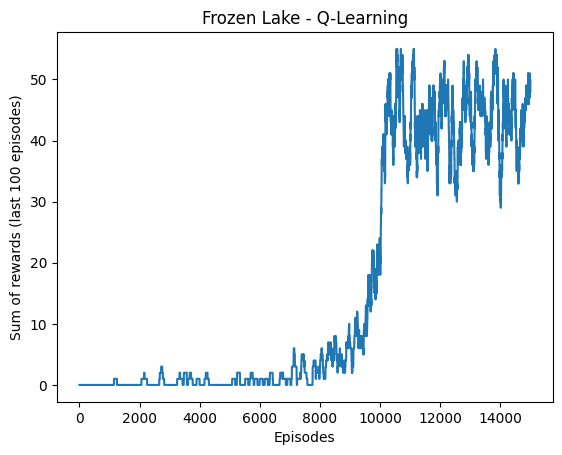

In [13]:
# Hyper Parameters
lr = 0.9    # Learning rate alpha
gamma = 0.9 # Discount factor gamma

epsilon = 1  # Exploration rate epsilon
epsilon_min = 0

n_episodes = 15000

# Train the agent
Q, rewards = train(
    lr, gamma, epsilon,
    epsilon_min, epsilon_decay,
    n_episodes
)

# Save the Q-table
np.save('./output/frozen_lake_q_table.npy', Q)

# Plot the rewards
sum_rewards = np.zeros(n_episodes)
for i in range(n_episodes):
    # Calculate the sum of rewards for every 100 episodes
    sum_rewards[i] = np.sum(rewards[max(0, i - 100):(i + 1)])
plt.title('Frozen Lake - Q-Learning')
plt.plot(sum_rewards)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards (last 100 episodes)')
plt.savefig('./output/frozen_lake_rewards.png')

In [3]:
# Evaluate the agent
Q = np.load('output/frozen_lake_q_table.npy')
# print(Q)

# Load the environment
env, n_states, n_actions = load_environment(False, is_slippery)

state = env.reset()[0]

done = False
while not done:
    env.render()
    action = np.argmax(Q[state, :])
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    state = next_state

env.close()

<img src="./output/frozen_lake_rewards.png" style="margin:auto"/>

<br>

<img src="./output/result.gif" style="margin:auto"/>